In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import segmentation_models_pytorch as smp
import os
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

# Configurations
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4
EPOCHS = 20
LR = 1e-4
IMG_SIZE = 640
NUM_CLASSES = 5  # Optic Disc, Microaneurysms, Hemorrhages, Soft Exudates, Hard Exudates
postfix = ['OD', 'MA', 'HE', 'SE', 'EX']

c:\Program Files\Python311\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Dataset Class
class IDRiDDataset(Dataset):
    def __init__(self, image_paths, mask_dirs, transform=None):
        self.image_paths = image_paths
        self.mask_dirs = mask_dirs  # List of 5 mask directories
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # print(img.shape)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)).transpose(2, 0, 1)  # Ensure consistent image size
        
        # Load multi-class masks
        mask = np.zeros((NUM_CLASSES, IMG_SIZE, IMG_SIZE), dtype=np.float32)
        image_name = os.path.basename(self.image_paths[idx]).split('.')[0]
        # print(image_name)
        
        for class_idx, mask_dir in enumerate(self.mask_dirs):
            mask_path = os.path.join(mask_dir, f"{image_name}_{postfix[class_idx]}.tif")
            # print(mask_path)  # Updated to handle .tif masks
            # print(mask_path)
            if os.path.exists(mask_path):
                class_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if class_mask is not None:
                    class_mask = cv2.resize(class_mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
                    mask[class_idx] = class_mask / 255.0   # Normalize to [0,1]
        
        # if self.transform:
        #     augmented = self.transform(image=img, mask=mask.transpose(1, 2, 0))  # Move mask channels to last dim
        #     img, mask = augmented['image'], augmented['mask'].permute(2, 0, 1)  # Restore channel-first format
        
        return img, mask

In [118]:
test_dataset[0][1]

IDRiD_01


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

    

In [99]:
os.path.basename("E:\segment_project\Segmentation\Groundtruths\TrainingSet\OpticDisc\IDRiD_01_OD.tif").split('.')[0]

'IDRiD_01_OD'

In [100]:
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    # A.HorizontalFlip(p=0.5),
    # A.RandomBrightnessContrast(p=0.2),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    ToTensorV2()
])

In [3]:
train_image_dir = "E:\segment_project\Segmentation\OriginalImages\TrainingSet"
train_mask_dirs = [
    "E:\segment_project\Segmentation\Groundtruths\TrainingSet\OpticDisc",
    "E:\segment_project\Segmentation\Groundtruths\TrainingSet\Microaneurysms",
    "E:\segment_project\Segmentation\Groundtruths\TrainingSet\Haemorrhages",
    "E:\segment_project\Segmentation\Groundtruths\TrainingSet\SoftExudates",
    "E:\segment_project\Segmentation\Groundtruths\TrainingSet\HardExudates"
]

test_image_dir = "E:\segment_project\Segmentation\OriginalImages\TestingSet"
test_mask_dirs = [
    "E:\segment_project\Segmentation\Groundtruths\TestingSet\OpticDisc",
    "E:\segment_project\Segmentation\Groundtruths\TestingSet\Microaneurysms",
    "E:\segment_project\Segmentation\Groundtruths\TestingSet\Haemorrhages",
    "E:\segment_project\Segmentation\Groundtruths\TestingSet\SoftExudates",
    "E:\segment_project\Segmentation\Groundtruths\TestingSet\HardExudates"
]

train_image_paths = sorted(glob(train_image_dir + "/*.jpg"))
test_image_paths = sorted(glob(test_image_dir + "/*.jpg"))

In [4]:
# image_filenames = {os.path.basename(f).split('.')[0] for f in image_paths}

# Split into train & test
# train_size = int(0.8 * len(image_paths))
# train_imgs, test_imgs = image_paths[:train_size], image_paths[train_size:]

train_dataset = IDRiDDataset(train_image_paths, train_mask_dirs)
test_dataset = IDRiDDataset(test_image_paths, test_mask_dirs)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [36]:
unet_model = smp.Unet(
    encoder_name="resnet34",  
    encoder_weights="imagenet",  
    in_channels=3,  
    classes=NUM_CLASSES  # One output channel per disease feature
)

In [37]:
unet_model.load_state_dict(torch.load("unet_60.pth"))

C:\Users\FUTURE TECH\AppData\Local\Temp\ipykernel_12052\2476817958.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_model.load_state_dict(torch.load("unet_60.pth"))


<All keys matched successfully>

In [7]:
dice_loss_fn = smp.losses.DiceLoss(mode="multilabel", from_logits=True)
bce_loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet_model.parameters(), lr=0.0001)

In [8]:
def train():
    unet_model.train()
    for epoch in range(EPOCHS):
        epoch_loss = 0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(DEVICE).float(), masks.to(DEVICE).float()
            imgs = imgs / 255.0
            optimizer.zero_grad()
            outputs = unet_model(imgs)
            dice_loss = dice_loss_fn(outputs, masks)  # Compute Dice loss
            bce_loss = bce_loss_fn(outputs, masks)  # Compute BCE loss

            loss = dice_loss + bce_loss
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss/len(train_loader):.4f}")
        

In [23]:
train()

Epoch [1/20], Loss: 0.3338
Epoch [2/20], Loss: 0.3274
Epoch [3/20], Loss: 0.3356
Epoch [4/20], Loss: 0.3201
Epoch [5/20], Loss: 0.3158
Epoch [6/20], Loss: 0.3153
Epoch [7/20], Loss: 0.3167
Epoch [8/20], Loss: 0.3071
Epoch [9/20], Loss: 0.3014
Epoch [10/20], Loss: 0.3070
Epoch [11/20], Loss: 0.3018
Epoch [12/20], Loss: 0.3030
Epoch [13/20], Loss: 0.2945
Epoch [14/20], Loss: 0.2974
Epoch [15/20], Loss: 0.2895
Epoch [16/20], Loss: 0.2868
Epoch [17/20], Loss: 0.2873
Epoch [18/20], Loss: 0.2920
Epoch [19/20], Loss: 0.2820
Epoch [20/20], Loss: 0.2860


In [38]:
def evaluate():
    unet_model.eval()
    with torch.no_grad():
        for imgs, masks in test_loader:
            imgs, masks = imgs.to(DEVICE).float(), masks.to(DEVICE).float()  # Convert masks to long
            outputs = unet_model(imgs)  # No softmax needed
            dice_loss = dice_loss_fn(outputs, masks)  # Compute Dice loss
            bce_loss = bce_loss_fn(outputs, masks)  # Compute BCE loss

            loss = dice_loss + bce_loss
            print(f"Test Loss: {loss.item()}")

In [39]:
evaluate()

Test Loss: 2.4552488327026367
Test Loss: 3.6356825828552246
Test Loss: 3.0214147567749023
Test Loss: 2.7444097995758057


KeyboardInterrupt: 

In [24]:
torch.save(unet_model.state_dict(), "unet_80.pth")

Unique values in mask: [0.         0.29803923]


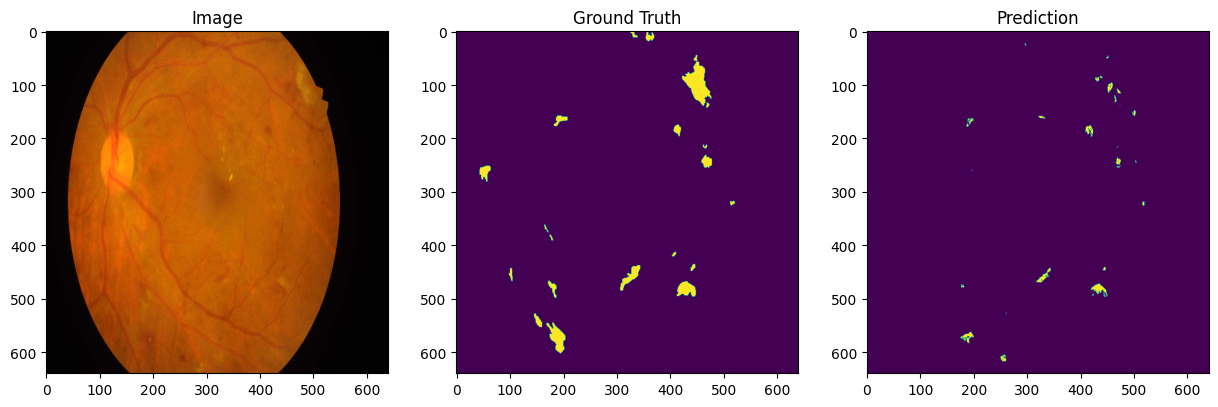

In [40]:
for imgs, masks in test_loader:
    imgs = imgs.to(DEVICE).float()
    masks =  masks.to(DEVICE).float()
    imgs = imgs / 255.0

    
    # Display the first image and its prediction
    img = imgs[1].cpu().numpy().transpose(1, 2, 0)
    mask = masks[1][2].cpu().numpy()
    pred = unet_model(imgs)

    outputs = torch.sigmoid(pred)
    outputs = (outputs > 0.3).float()

    out = outputs[1][2].cpu().detach().numpy() 
    print("Unique values in mask:", np.unique(mask))
    # dice = los(out, mask)
    # print(f"Dice Score: {dice:.4f}")
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img, cmap=None)
    ax[0].set_title('Image')
    ax[1].imshow(mask)
    ax[1].set_title('Ground Truth')
    ax[2].imshow(out)
    ax[2].set_title('Prediction')
    plt.show()
    break

In [38]:
def dice_score(pred, target, epsilon=1e-6):
    intersection = (pred * target).sum()
    return (2. * intersection + epsilon) / (pred.sum() + target.sum() + epsilon)

In [48]:
torch.unique(torch.tensor(out))

tensor([0., 1.])

In [39]:
cv2.imread("E:\segment_project\Segmentation\Groundtruths\TrainingSet\OpticDisc\IDRiD_01.tif")